# 21cmFASTv4 Database usage tutorial

Tutorial for using the [21cmFASTv4](https://github.com/nikos-triantafyllou/21cmFAST) database created with https://github.com/nikos-triantafyllou/Database-21cmFASTv4 <br>
**Author:** Nikolaos (Nikos) Triantafyllou<br>
**Date:** January 2025

---


### Table of Contents <a class="anchor" id="top"></a>

* [0. Info](#info)
    * [0.1 Imports](#imports)
    * [0.2 Loading a file and reading general information](#loading)
* [1. Simulation Parameters](#simulationparams)
* [2. Lightcones](#lightcones)
    * [2.1 Power Spectra](#powerspectra)
* [3. Coeval Data](#coevaldata)
    * [3.1 $x_{HI}$, $T_{kin\_all\_gas}$, brightness_temp](#first3)
    * [3.2 tau_e](#taue)
    * [3.3 HMF (a)](#hmf)
    * [3.4 UV Luminosity Function (a)](#turnoverluminosity)
* [4. Halo Data](#halodata)
    * [4.1 HMF (b)](#hmf2)
    * [4.2 UV Luminosity Function (b)](#uvlf2)
    * [4.3 Stellar Halo Mass Relation (Mstar vs Mhalo)](#starrng)
    * [4.4 Star Formation Main Sequence (SFR vs Mstar)](#sfrrng)   
    
    
    
    
Appendix
* [A.1. Plus Minus Parameters](#plusminus)

---

# 0. Info <a class="anchor" id="info"></a>

Each file is saved in a `hdf5` format and named after an ID that corresponds to the random seed used to run the database, e.g. `id_22.h5`. Currently located at `/projects/cosmo_database/ntriantafyllou/DATABASE_21cmFASTv4/data/` on Trantor HPC system. <br>
Indicative simulations run with fiducial parameters or with only varying 1 parameter can be found at `/projects/cosmo_database/ntriantafyllou/DATABASE_21cmFASTv4/indicative_simulations/`
(indicative simulations files can have slightly different file structure).

Fiducial parameters can be found at the `src/FIDUCIAL_PARAMETERS.json` github file. To see what the parameters are check [21cmFAST's github](https://github.com/nikos-triantafyllou/21cmFAST)  or [documentation](https://21cmfast.readthedocs.io/en/latest/) (be sure to look at the correct version).

Varying parameters are the following:<br>

```python
"SIGMA_8", 
"L_X",
"NU_X_THRESH",
"F_STAR10",
"ALPHA_STAR",
"F_ESC10",
"ALPHA_ESC",
"t_STAR",
"SIGMA_SFR_LIM",
"M_TURN" 
```

As well as `random_seed`, `N_threads` and their mini-halos counterparts (dependent on the previous params in a way specified in `src/FIDUCIAL_PARAMETERS.json`)


**Sampling**<br>
First 2000 simulations were run based on a Latin Hypercube Sampling (LHS) according to the uniform distributions as described in the `src/LHS_sampler.py` file on github.
Following simulations were run based on a chi^2 effective likelihood on luminosity functions using these initial 2000 simulations.


**File structure**<br>
Files have the structure drawn in `DatabaseTree.pdf` on github:

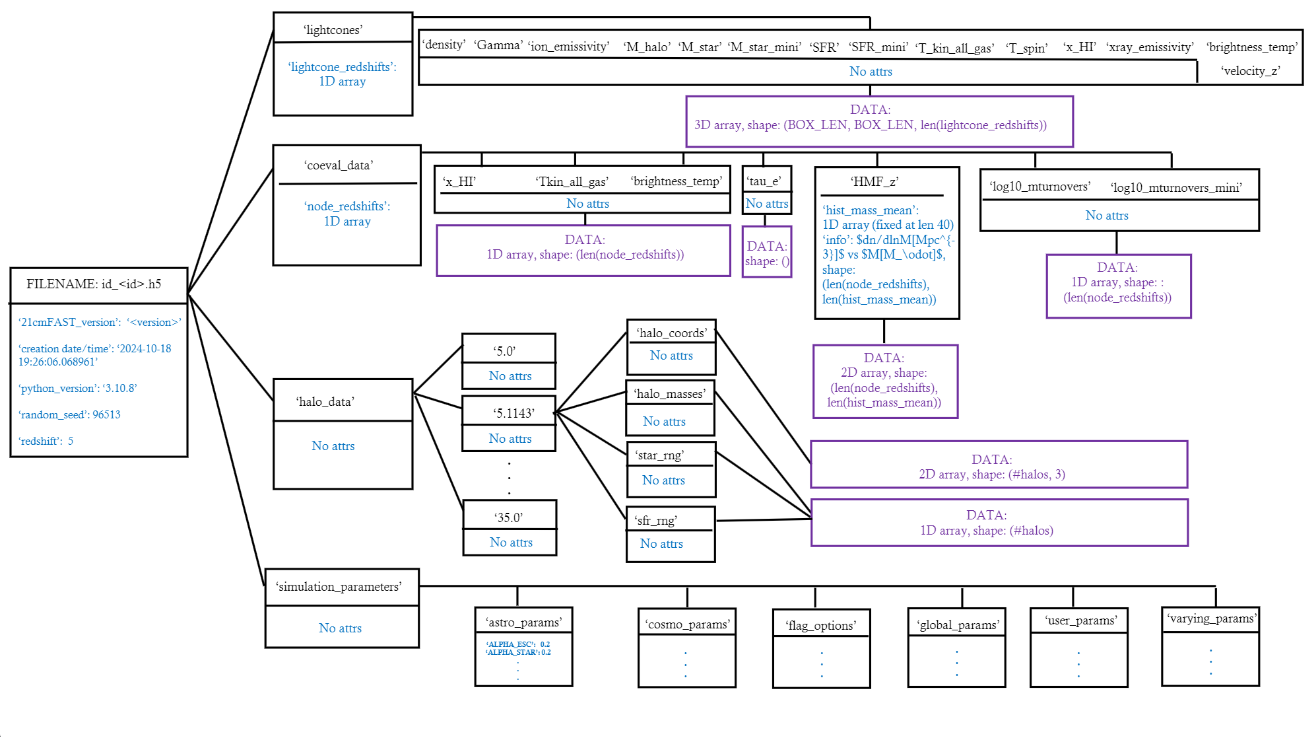

File categories:
- **lightcones:** Includes all the 14 lightcones named in the above image. 
- **coeval_data:** Includes data saved from coeval boxes (simulation boxes) during the simulations that are not saved eventually. Includes global quantities, tau_e, turnover masses for teh calculation of UV luminosity functions (UVLFs) and finaly already computed Halo Mass Functions (HMFs) from individual halos in each box. 
- **halo_data:** Includes data from 6 different redshifts: $z=5.5, 6, 6.5, 7, 8, 9$. Each redshift has information about the position, masses, and encoded SFR and stellar masses of individual halos of $M_h> 10^{10}M_\odot$.
- **simulation_parameters:**  The parameters used to run each simulation. `global_params` not saved for the first 2000 simulations but they remain constant to their default values throughout. 

### 0.1 Imports <a class="anchor" id="imports"></a>

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import py21cmfast_tools as p21c_tools
import py21cmfast as p21c


plt.rcParams.update({'font.size': plt.rcParamsDefault['font.size']})
plt.rcParams['lines.linewidth'] = plt.rcParamsDefault['lines.linewidth']


import powerbox as pbox
from importlib import reload
import n_plotting
import d_plotting
import d_get_properties
import d_utils
from useful_functions.get_bardeen_PS import power_21c

EoR_color already loaded
EoR_color already loaded


### 0.2 Loading a file and reading general information <a class="anchor" id="loading"></a>

In [4]:
# Load the file
# hdf = h5py.File('/projects/cosmo_database/ntriantafyllou/DATABASE_21cmFASTv4/data/id_1091.h5', 'r')
hdf = h5py.File('/projects/cosmo_database/ntriantafyllou/DATABASE_21cmFASTv4/indicative_simulations/plus_minus_new/id_21.h5', 'r')
# hdf = h5py.File('/projects/cosmo_database/ntriantafyllou/DATABASE_21cmFASTv4/indicative_simulations/zero_variance_sfr/id_31.h5', 'r')

# And let's see some general information
dict(hdf.attrs)

{'21cmFAST_version': '3.4.1.dev523+g33e40a87',
 'creation date/time': '2025-03-03 19:19:18.802690',
 'python_version': '3.11.6',
 'random_seed': 23,
 'redshift': 5}

## 1. Simulation Parameters <a class="anchor" id="simulationparams"></a>

In [5]:
# Let's see what the varying parameters are
dict(hdf['simulation_parameters']['varying_params'].attrs)
# dict(id_22['simulation_parameters']['astro_params'].attrs)
# dict(id_22['simulation_parameters']['cosmo_params'].attrs)
# dict(id_22['simulation_parameters']['flag_options'].attrs)
# dict(id_22['simulation_parameters']['global_params'].attrs)
# dict(id_22['simulation_parameters']['user_params'].attrs)

{'ALPHA_ESC': -0.5,
 'ALPHA_STAR': 0.5,
 'F_ESC10': -1.4,
 'F_STAR10': -1.3,
 'L_X': 40.5,
 'M_TURN': 5,
 'NU_X_THRESH': 500.0,
 'SIGMA_8': 0.811,
 'SIGMA_SFR_LIM': 0.19,
 'random_seed': 23,
 't_STAR': 0.5}

## 2. Lightcones <a class="anchor" id="lightcones"></a>

Let's plot the brightness temperature

In [6]:
# Let's get the lightcone 
Tb_lightcone = hdf['lightcones']['brightness_temp'][:]
print('Lightcone shape:', Tb_lightcone.shape)

# And the redshifts corresponding to the 3rd dimention of the lightcone
lightcone_redshifts = dict(hdf['lightcones'].attrs)['lightcone_redshifts']

Lightcone shape: (200, 200, 2553)


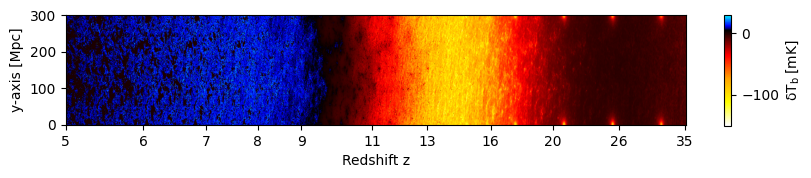

In [7]:
# Let's plot it!
n_plotting.plot_lc(Tb_lightcone, lightcone_redshifts);

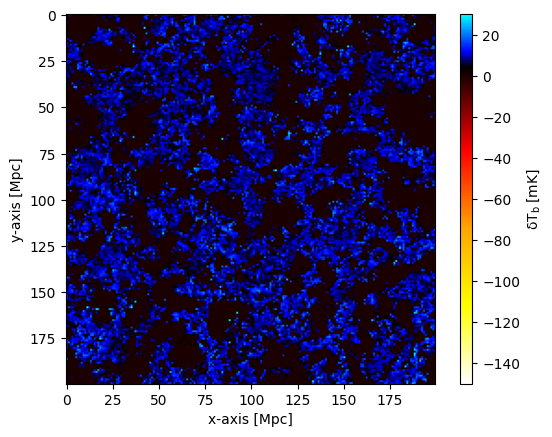

In [8]:
# Maybe also a slice
n_plotting.plot_box_slice(Tb_lightcone[:,:,134]);

And now let's plot the density

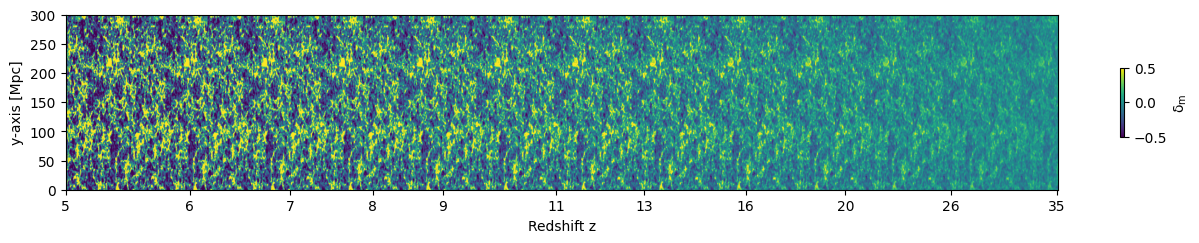

In [9]:
# Let's get the lightcone 
density_lightcone = hdf['lightcones']['density'][:]

# Let's plot it!
fig, ax = plt.subplots(figsize=((16,5)))
plt.imshow(density_lightcone[:,7,], cmap='viridis', extent=[0,2553,0,300], norm='linear',vmin=-0.5,vmax=0.5)
ax.set_aspect(1.5)

# redshift_arr = lightcone_redshifts
zs= np.concatenate((np.arange(5,15,1), np.arange(15,23,2)))
zs = np.concatenate((zs,np.arange(23,37,3)))
zs=[5,6,7,8,9,11,13,16,20,26,35]

z_positions=[]
for z in zs:
    z_positions.append( np.where(abs(lightcone_redshifts-z) ==  min(abs(lightcone_redshifts-z)))[0][0] )

ax.set_xticks(ticks = z_positions, labels= zs)

plt.colorbar(shrink=0.18, aspect=16, label=r'$\rm \delta_m$')

plt.xlabel('Redshift z')
plt.ylabel('y-axis [Mpc]')
plt.show()

### 2.1 Power spectra <a class="anchor" id="powerspectra"></a>

In [10]:
# This might take a while (approx 3mins)
ps = p21c_tools.calculate_ps(lc=Tb_lightcone,
                        lc_redshifts = lightcone_redshifts,
                        box_length = 300.0,
                        #    box_side_shape = 200,
                        calc_1d = True,
                        calc_2d = False,
                        )

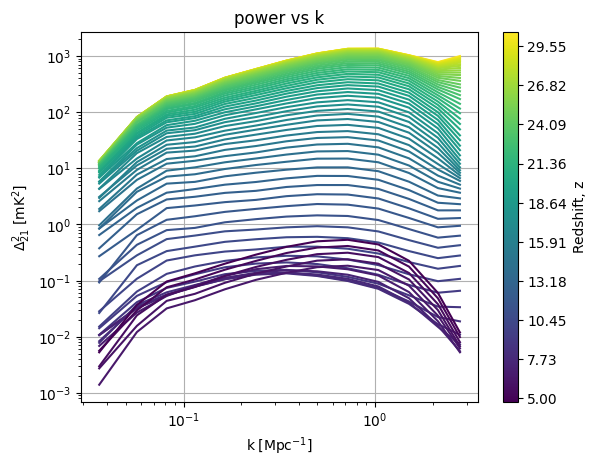

In [100]:
# Plot power vs k 
fig = d_plotting.plot_ps_1D(ps)

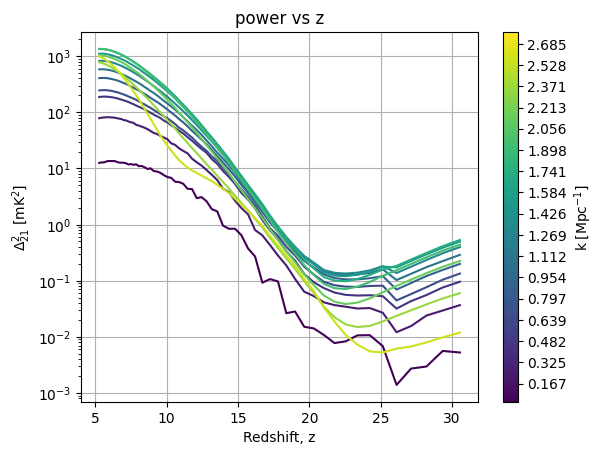

In [104]:
# Plot power vs z 
fig = d_plotting.plot_ps_1D_2(ps)

## 3. Coeval data <a class="anchor" id="coevaldata"></a>

### 3.1) $x_{HI}$, $T_{kin\_all\_gas}$, brightness_temp <a class="anchor" id="first3"></a>

In [11]:
# Let's get the neutral fraction
x_HI_coev = hdf['coeval_data']['x_HI'][:]
print('Coeval quantity shape:', x_HI_coev.shape)

# And the redshifts corresponding to the 92 values of the previus array
node_redshifts = dict(hdf['coeval_data'].attrs)['node_redshifts']
print('Node redshifts shape:', node_redshifts.shape)

Coeval quantity shape: (92,)
Node redshifts shape: (92,)


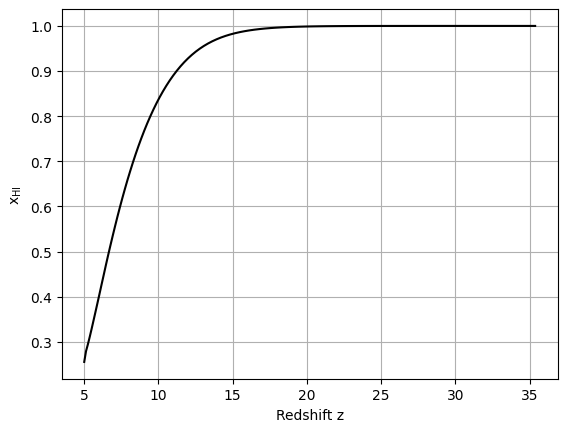

False

In [13]:
# Let's plot it!
fig, ax = plt.subplots()
plt.plot(node_redshifts, x_HI_coev, color='black')
plt.xlabel('Redshift z')
plt.ylabel(r'$\rm x_{HI}$')
plt.grid()
plt.show()

d_utils.is_xHI_flagged(x_HI_coev)

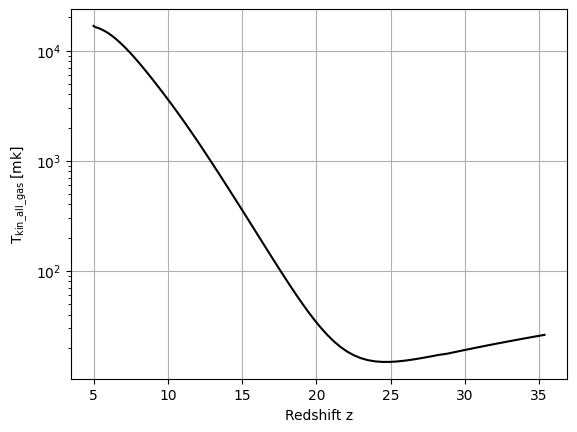

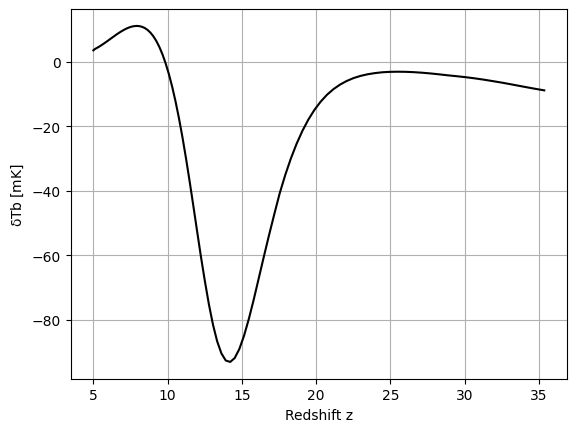

In [14]:
# Let's plot the other 2 quantities
T_kin_all_gas_coev = hdf['coeval_data']['T_kin_all_gas'][:]
Tb_coev = hdf['coeval_data']['brightness_temp'][:]

# Let's plot them!
fig, ax = plt.subplots()
plt.plot(node_redshifts, T_kin_all_gas_coev, color='black')
plt.xlabel('Redshift z')
plt.ylabel(r'$\rm T_{kin\_all\_gas}\;[mk]$')
plt.yscale('log')
plt.grid()
plt.show()

fig, ax = plt.subplots()
plt.plot(node_redshifts, Tb_coev, color='black')
plt.xlabel('Redshift z')
plt.ylabel(r'$\rm \delta Tb\; [mK]$')
plt.grid()
plt.show()

### 3.2) tau_e <a class="anchor" id="taue"></a>

In [15]:
# The optical depth
tau_e =np.array( hdf['coeval_data']['tau_e'] )
print(tau_e)

0.05436756834387779


### 3.3) HMF (a) <a class="anchor" id="hmf"></a>

This is the first way that HMFs can be accessed, these HMFs are already saved in the file as arrays and were created from data of individual halos for every node redshift.

In [16]:
# Get the data from the file
node_redshifts = hdf['coeval_data'].attrs['node_redshifts']
hist_mass_mean = hdf['coeval_data']['HMF_z'].attrs['hist_mass_mean']
HMF_arr = hdf['coeval_data']['HMF_z'][:]

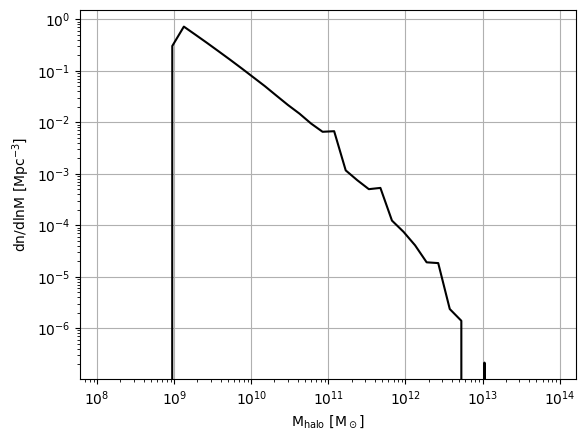

In [17]:
# Plot 1 hmf 
plt.plot(hist_mass_mean, HMF_arr[91], color='black')

# Make the plot pretty
plt.xlabel(r'$\rm M_{\rm halo}~[M_\odot]$')
plt.ylabel(r'$\rm dn/dlnM~[Mpc^{-3}]$')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.show()

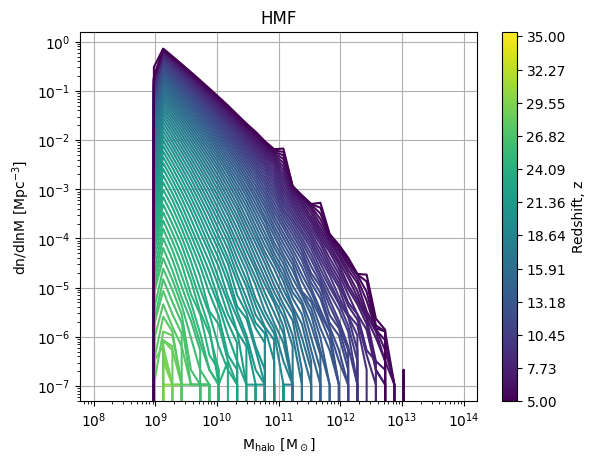

In [18]:
# Or all of them!
d_plotting.plot_hmf_z(HMF_arr, hist_mass_mean, node_redshifts)

### 3.4) UV Luminosity Function (a) <a class="anchor" id="turnoverluminosity"></a>

This is the first way that UVLFs can be accessed. Let's use the turnover masses saved to calculate UVLFs.

In [19]:
# Format the parameters 
user_params = dict(hdf['simulation_parameters']['user_params'].attrs)
cosmo_params = dict(hdf['simulation_parameters']['cosmo_params'].attrs)
astro_params = dict(hdf['simulation_parameters']['astro_params'].attrs)
flag_options = dict(hdf['simulation_parameters']['flag_options'].attrs)


input_params_struct = p21c.InputParameters(
                cosmo_params=p21c.CosmoParams.new(cosmo_params),
                astro_params=p21c.AstroParams.new(astro_params),
                user_params=p21c.UserParams.new(user_params),
                flag_options=p21c.FlagOptions.new(flag_options),
                random_seed=hdf.attrs['random_seed'],
                node_redshifts = hdf['coeval_data'].attrs['node_redshifts'],
            )

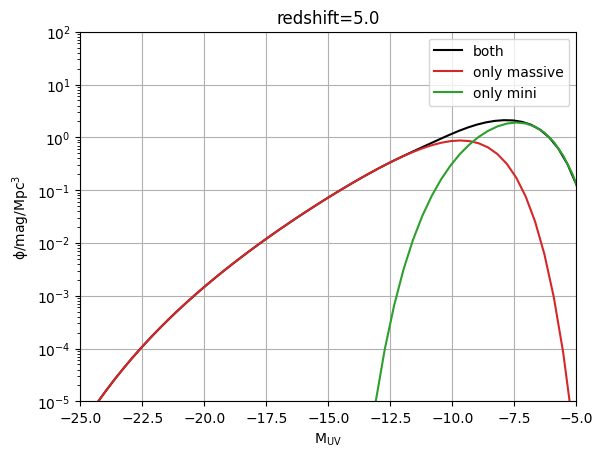

In [20]:
# Load data
node_redshifts = hdf['coeval_data'].attrs['node_redshifts']
log10_mturnovers = hdf['coeval_data']['log10_mturnovers'][:]
log10_mturnovers_mini = hdf['coeval_data']['log10_mturnovers_mini'][:]

# Here z_uv is node redshifts but it can be whatever
z_uv=node_redshifts

# Run the function from 21cmFAST
LF_arr=p21c.compute_luminosity_function(
    redshifts = z_uv,
    inputs=input_params_struct,
    nbins=100,
    mturnovers=10**log10_mturnovers,
    mturnovers_mini=10**log10_mturnovers_mini,
    component='both',
)    
LF_arr_0 = LF_arr[0]
LF_arr_1 = LF_arr[1]
LF_arr_2 = LF_arr[2]


z_id=-1

fig, ax = plt.subplots()
ax.plot(LF_arr_0[z_id,:], 10**LF_arr_2[z_id,:], color='black', label='both')
# Make plot pretty
ax.set_xlabel(r'$\rm M_{UV}$')
ax.set_ylabel(r'$\rm \phi /mag/Mpc^3$')
ax.set_title(     label = f'redshift={round(node_redshifts[z_id], 1)}' )
ax.set_xlim((-25,-5))
ax.set_ylim((1e-5,1e2))
ax.set_yscale('log')
ax.grid()




# Calculate and plot also the UVLF of atomically cooled and molecularly cooled halos separately (i.e. big halos and mini-halos)
LF_arr=p21c.compute_luminosity_function(
    redshifts = z_uv,
    inputs=input_params_struct,
    nbins=100,
    mturnovers=10**log10_mturnovers,
    mturnovers_mini=10**log10_mturnovers_mini,
    component='acg',
)    
LF_arr_0_acg = LF_arr[0]
LF_arr_1_acg = LF_arr[1]
LF_arr_2_acg = LF_arr[2]

ax.plot(LF_arr_0_acg[z_id,:], 10**LF_arr_2_acg[z_id,:], color='tab:red', label='only massive')

LF_arr=p21c.compute_luminosity_function(
    redshifts = z_uv,
    inputs=input_params_struct,
    nbins=100,
    mturnovers=10**log10_mturnovers,
    mturnovers_mini=10**log10_mturnovers_mini,
    component='mcg',
)    
LF_arr_0_mcg = LF_arr[0]
LF_arr_1_mcg = LF_arr[1]
LF_arr_2_mcg = LF_arr[2]

ax.plot(LF_arr_0_mcg[z_id,:], 10**LF_arr_2_mcg[z_id,:], color='tab:green', label='only mini')


plt.legend()
plt.show()

## 4. Halo data <a class="anchor" id="halodata"></a>

In this subgroup of the file where the data from the individual halos are stored. 
The subgroup `halo_data` includes data from 6 different redshifts: $z=5.5, 6, 6.5, 7, 8, 9$. Each redshift has information about the position, masses, and encoded SFR and stellar masses of individual halos of $M_h> 10^{10}M_\odot$.

### 4.1) HMF (b) <a class="anchor" id="hmf2"></a>

This is the second way that HMFs can be accessed, these HMFs can be created from individual halos from any one of the 6 redshifts saved.

In [21]:
# Let's see the available redshifts
halo_data_redshifts = list(hdf['halo_data'].keys())
print('The available redshifts to access the halo data are:', halo_data_redshifts)

The available redshifts to access the halo data are: ['5.49459296', '6.029956286013594', '6.460245850367914', '7.075210029944779', '8.09399806338753', '9.04050868612415']


In [22]:
# Let's consider the z~5.5 case
hmass_arr  = hdf['halo_data']['5.49459296']['halo_masses'][:]

In [23]:
# Set up variables needed for the HMF
box_len = user_params['BOX_LEN']
BoxSize = box_len 
min_mass = 1e10 #minimum mass in Msun
max_mass = 1e14 #maximum mass in Msun
bins     = 40   #number of bins in the HMF
bins_mass = np.logspace(np.log10(min_mass), np.log10(max_mass), bins+1)
mass_mean = 10**(0.5*(np.log10(bins_mass[1:])+np.log10(bins_mass[:-1])))
dM        = bins_mass[1:] - bins_mass[:-1]

In [24]:
# Calculate the histogram
hmf = mass_mean * np.histogram(hmass_arr, bins=bins_mass)[0]/(dM*BoxSize**3)

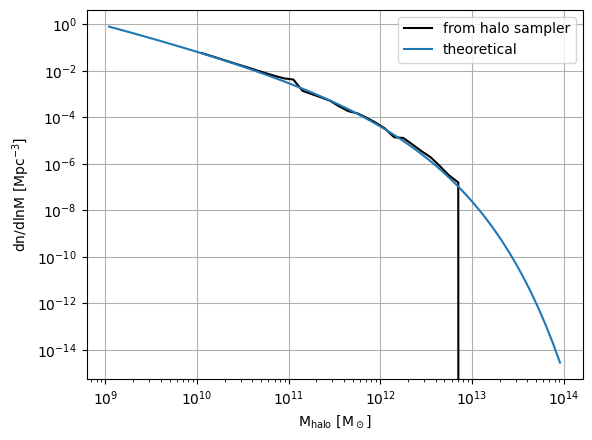

In [25]:
# Let's plot it!
plt.plot(mass_mean, hmf, color='black', label='from halo sampler')

# Plot also the theoretical unconditional hmf used internally
centres, hmf_t = d_utils.get_theoretical_hmf(input_params_struct, 5.5)
plt.plot(centres, hmf_t, label='theoretical')

# Make plot pretty
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\rm M_{\rm halo}~[M_\odot]$')
plt.ylabel(r'$\rm dn/dlnM~[Mpc^{-3}]$')
plt.grid()
plt.legend()
plt.show()

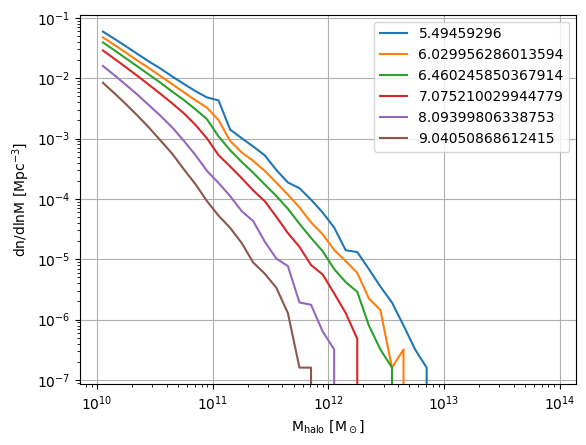

In [26]:
# Now let's plot all of them in the same plot
fig, ax = plt.subplots()

for redshift in halo_data_redshifts: 
    hmass_arr = hdf['halo_data'][redshift]['halo_masses'][:]
    hmf = mass_mean * np.histogram(hmass_arr, bins=bins_mass)[0]/(dM*BoxSize**3)
    ax.plot(mass_mean, hmf, label = redshift)
    
# Make plot pretty 
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\rm M_{\rm halo}~[M_\odot]$')
plt.ylabel(r'$\rm dn/dlnM~[Mpc^{-3}]$')
plt.legend()
plt.grid()
plt.show()

### 4.2) UV Luminosity Function (b) <a class="anchor" id="uvlf2"></a>

This is the second way that UVLFs can be accessed. Let's use the individual halo properties (Star Formation Rates, SFRs) saved to calculate the UVLFs.

In [27]:
halo_data_redshifts = list(hdf['halo_data'].keys())
print('The available redshifts to access the halo data are:', halo_data_redshifts)

The available redshifts to access the halo data are: ['5.49459296', '6.029956286013594', '6.460245850367914', '7.075210029944779', '8.09399806338753', '9.04050868612415']


In [28]:
n_halos=1000000
hdf_group = hdf['halo_data'][halo_data_redshifts[0]]
total_number_of_halos = len(hdf_group['halo_masses'][:])
print('Total number of halos:', total_number_of_halos)

Total number of halos: 1457677


Let's get the properties of the halos in our file by post-processing the `rng` quantities.

Here we use the `d_get_properties.get_properties` function but one may use the `convert_halo_properties` function located in github's `21cmFAST/src/py21cmfast/wrapper
/cfuncs.py`

In [29]:
hm_cat, sm_cat, sfr_cat = d_get_properties.get_properties(redshift     = halo_data_redshifts[0], 
                                                          n_halos      = n_halos, 
                                                          random_seed  = hdf.attrs['random_seed'], 
                                                          hdf_group    = hdf_group, 
                                                          cosmo_params = p21c.CosmoParams.new(dict(hdf['simulation_parameters']['cosmo_params'].attrs)), 
                                                          user_params  = p21c.UserParams.new(dict(hdf['simulation_parameters']['user_params'].attrs)), 
                                                          flag_options = p21c.FlagOptions.new(dict(hdf['simulation_parameters']['flag_options'].attrs)), 
                                                          astro_params = p21c.AstroParams.new(dict(hdf['simulation_parameters']['astro_params'].attrs)))

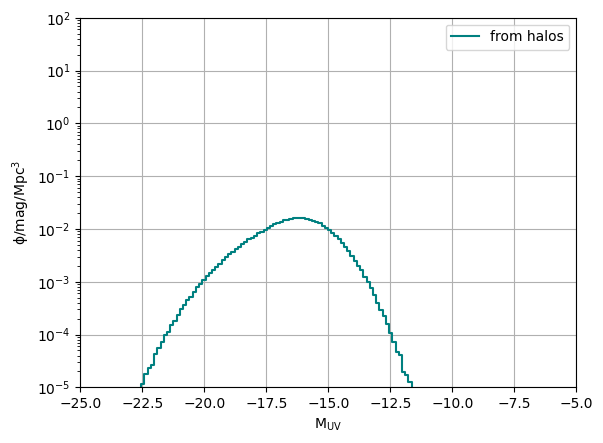

In [30]:
# Relations used also in 21cmFAST (so also for the previous UVLFs)
Luv_over_SFR = 1.0 / 1.15 / 1e-28 # [M_solar yr^-1/erg s^-1 Hz^-1], G. Sun and S. R. Furlanetto (2016) MNRAS, 417, 33)
Muv_cat = 51.63 - 2.5*np.log10(sfr_cat*Luv_over_SFR)

hist, bin_edges = np.histogram(Muv_cat, bins=100)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width = bin_edges[3]-bin_edges[2]

# Normalize the histogram 1. by the survey volume, 2. bin width (for /mag/Mpc^3) and 3. by the number of sampled halos out of the total number 
sim_volume= 300*300*300
hist = hist/ (bin_width * sim_volume)
hist*= total_number_of_halos/n_halos


fig, ax = plt.subplots()
ax.plot(bin_centers, hist, drawstyle='steps-mid',color='teal', label='from halos')


# Make the plot look pretty
ax.set_xlabel(r'$\rm M_{UV}$')
ax.set_ylabel(r'$\rm \phi /mag/Mpc^3$')
ax.set_xlim((-25,-5))
ax.set_ylim((1e-5,1e2))
ax.set_yscale('log')
ax.set_yscale('log')
ax.legend()
plt.grid()
plt.show()

Let's compare it with the luminosity functions that we got in the previous section.

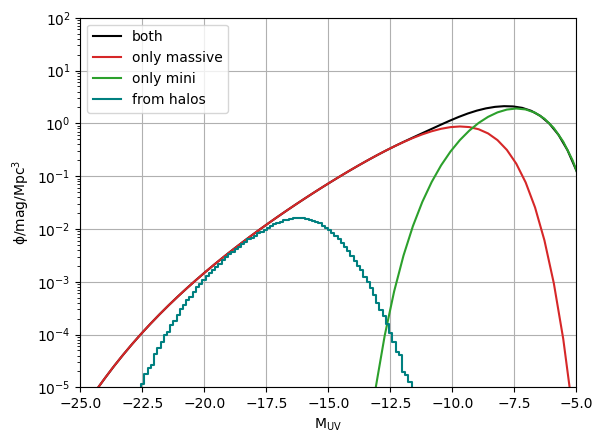

In [31]:
z_id=-1

fig, ax = plt.subplots()
ax.plot(LF_arr_0[z_id,:], 10**LF_arr_2[z_id,:], color='black', label='both')
ax.plot(LF_arr_0_acg[z_id,:], 10**LF_arr_2_acg[z_id,:], color='tab:red', label='only massive')
ax.plot(LF_arr_0_mcg[z_id,:], 10**LF_arr_2_mcg[z_id,:], color='tab:green', label='only mini')
ax.plot(bin_centers, hist, drawstyle='steps-mid',color='teal', label='from halos')


# Make the plot look pretty
ax.set_xlabel(r'$\rm M_{UV}$')
ax.set_ylabel(r'$\rm \phi /mag/Mpc^3$')
ax.set_xlim((-25,-5))
ax.set_ylim((1e-5,1e2))
ax.set_yscale('log')
ax.set_yscale('log')
ax.legend()
plt.grid()
plt.show()

### 4.3) Stellar Halo Mass Relation (Mstar vs Mhalo) <a class="anchor" id="starrng"></a>

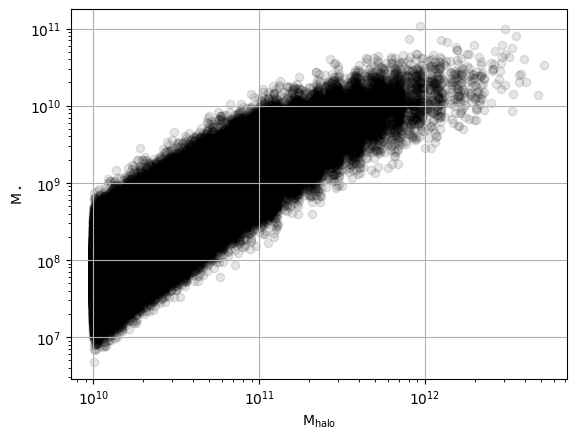

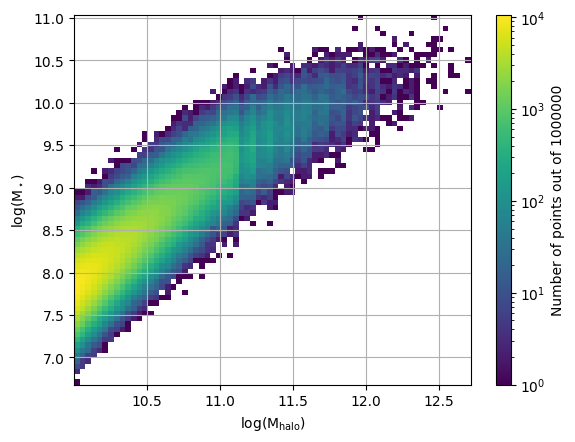

In [32]:
# Mstar vs Mhalo----------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots()
ax.scatter(hm_cat,sm_cat,color='black', alpha=0.1)

# Make the plot pretty
plt.xlabel(r'$\rm M_{halo}$')
plt.ylabel(r'$\rm M_\star$')
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.show()

fig, ax = plt.subplots()
plt.hist2d(np.log10(hm_cat), np.log10(sm_cat),bins=70,alpha=1,
                     cmap='viridis',
                      norm='log'
                    )

# Make the plot pretty
plt.xlabel(r'$\rm log(M_{halo})$')
plt.ylabel(r'$\rm log(M_\star)$')
plt.colorbar(label=f'Number of points out of {n_halos}', aspect=25)
plt.grid()
plt.show()

### 4.4) Star Formation Main Sequence (SFR vs Mstar) <a class="anchor" id="sfrrng"></a>

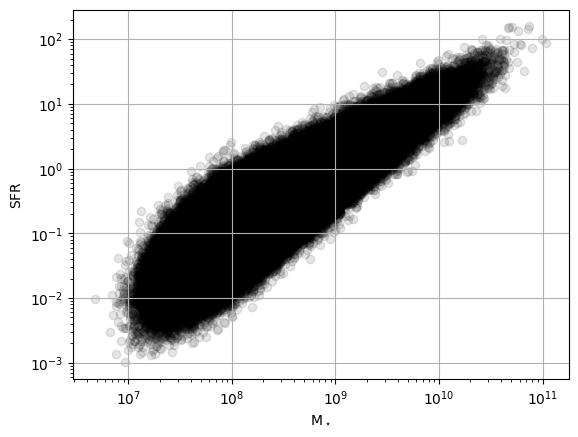

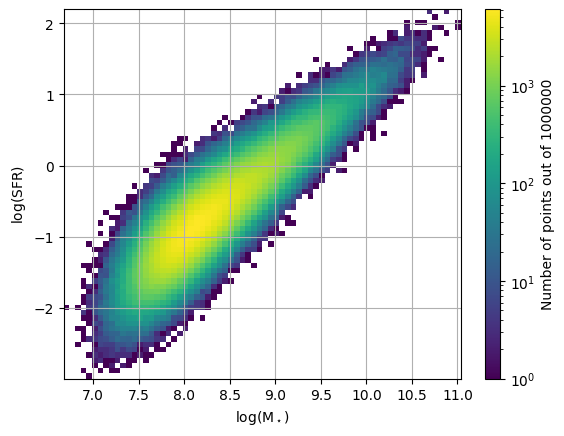

In [33]:
# SFR vs Mstar----------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots()
ax.scatter(sm_cat,sfr_cat,color='black', alpha=0.1)
# plt.title(label=r'$\rm M_{star} \; vs \; M_{halo}$')
plt.xlabel(r'$\rm M_\star$')
plt.ylabel(r'$\rm SFR$')
plt.yscale('log')
plt.xscale('log')
plt.grid()

fig, ax = plt.subplots()
plt.hist2d(np.log10(sm_cat), np.log10(sfr_cat),bins=70,alpha=1,
                     cmap='viridis',
                      norm='log'
                    )
plt.xlabel(r'$\rm log(M_\star)$')
plt.ylabel(r'$\rm log(SFR)$')
plt.colorbar(label=f'Number of points out of {n_halos}', aspect=25)
plt.grid()

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


# Appendix

### A.1) A.1. Plus Minus Parameters <a class="anchor" id="plusminus"></a>

Here we access the directory of `indicative_simulations` and in particular the `plus_minus` directory. Inside of it, there are runs that correspond to fiducial parameters, choosing to increase or decrease only one parameter out of the varying parameters.

In [4]:
# The ids of the filenames that correspond to the following increases or decreases for the parameters:
#21: fiducial
run_names = {22: 'SIGMA_8_minus',
        23: 'SIGMA_8_plus',
        24: 'L_X_minus',
        25: 'L_X_plus',
        26: 'NU_X_THRESH_minus',
        27: 'NU_X_THRESH_plus',
        28: 'F_STAR10_minus',
        29: 'F_STAR10_plus',
        30: 'ALPHA_STAR_minus',
        31: 'ALPHA_STAR_plus',
        32: 'F_ESC10_minus',
        33: 'F_ESC10_plus',
        34: 'ALPHA_ESC_minus',
        35: 'ALPHA_ESC_plus',
        36: 't_STAR_minus',
        37: 't_STAR_plus',
        38: 'SIGMA_SFR_LIM_minus',
        39: 'SIGMA_SFR_LIM_plus',
        40: 'M_TURN_minus',
        41: 'M_TURN_plus'}

Here we plot a large plot showing the resulting differences in some key resulting quantities:

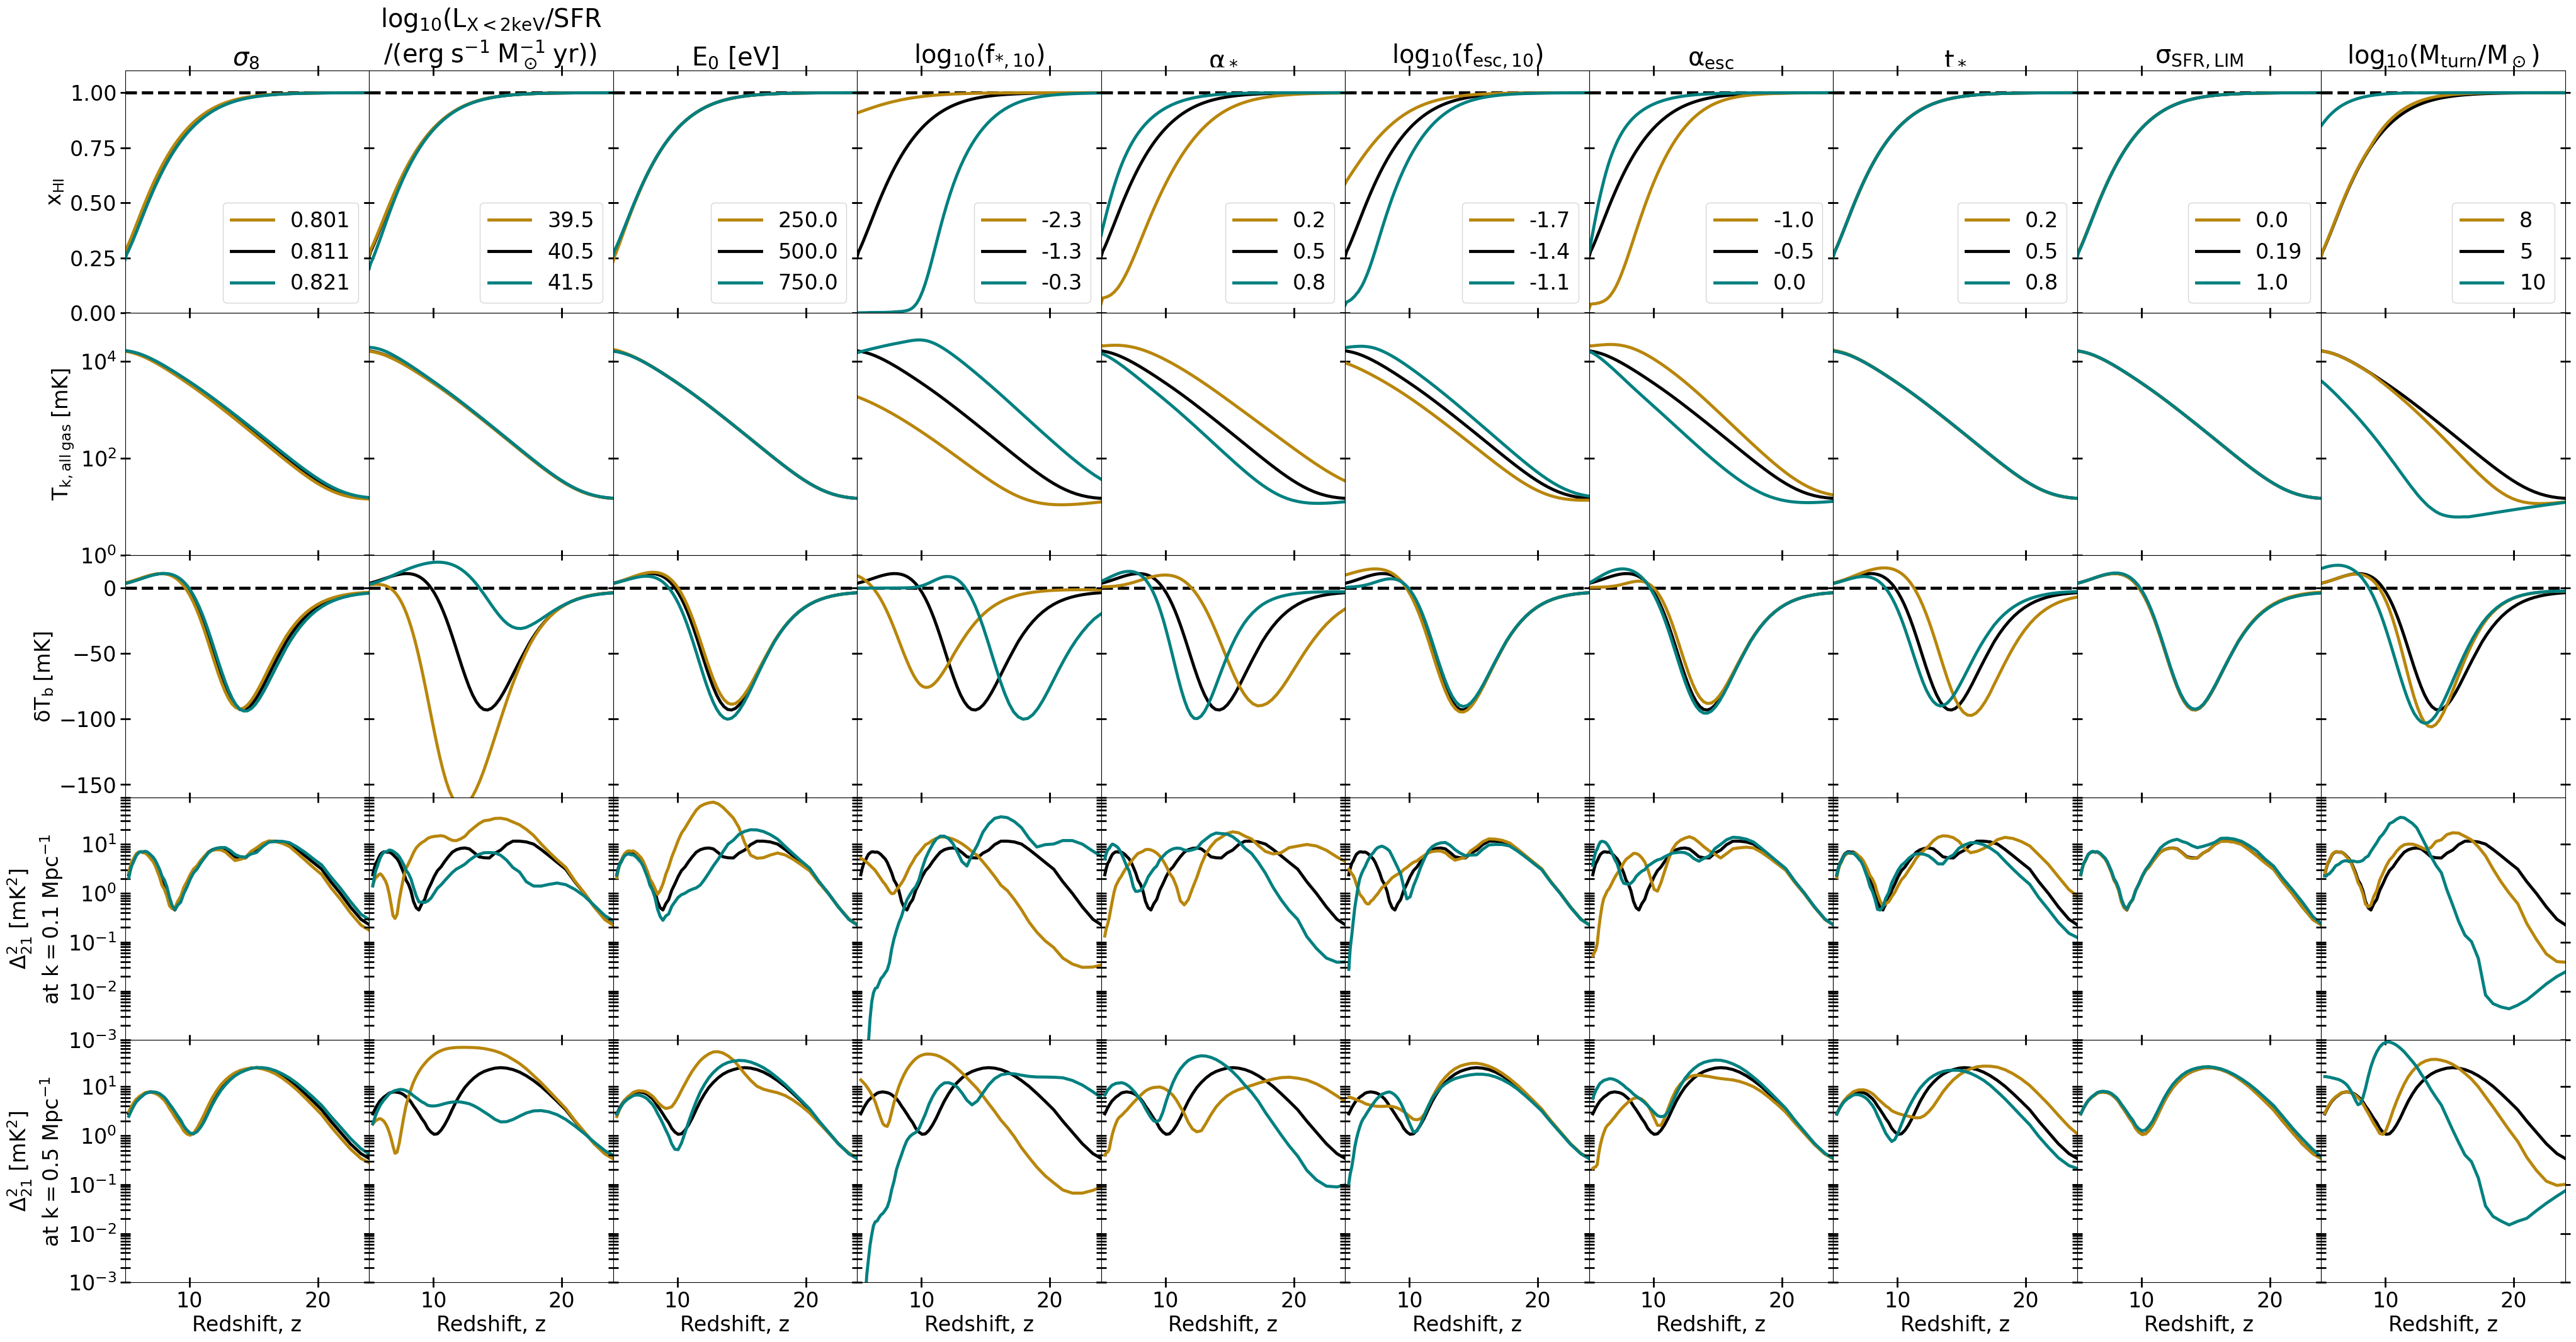

In [5]:
# Get data from file
plus_minus_location = '/projects/cosmo_database/ntriantafyllou/DATABASE_21cmFASTv4/indicative_simulations/plus_minus_new'
filename_fid = f'{plus_minus_location}/id_21.h5'
with h5py.File(filename_fid, 'r') as hdf:
                varying_params = dict(hdf['simulation_parameters']['varying_params'].attrs)
                lightcone_redshifts = hdf['lightcones'].attrs['lightcone_redshifts']
                node_redshifts_fid = hdf['coeval_data'].attrs['node_redshifts']
                Tb_global_fid = hdf['coeval_data']['brightness_temp'][:]
                xH_global_fid = hdf['coeval_data']['x_HI'][:]
                Tk_all_gas_fid = hdf['coeval_data']['T_kin_all_gas'][:]
                hmf           = hdf['coeval_data']['HMF_z'][-1,:]
                hmf_mean_mass  = hdf['coeval_data']['HMF_z'].attrs['hist_mass_mean']   
                hmf2            = hdf['coeval_data']['HMF_z'][-40,:]
                lc = hdf['lightcones']['brightness_temp'][:]

# Load pre-computed power spectra from file not to compute again because it takes a while

kps_location = '/projects/cosmo_database/ntriantafyllou/DATABASE_21cmFASTv4/indicative_simulations/plus_minus/kps'
run_name='fiducial'
ps21_redshifts_fid = np.load(f'{kps_location}/ps21_redshifts.npy')
ps21_k01_fid = np.load(f'{kps_location}/{run_name}_01.npy')
ps21_k05_fid = np.load(f'{kps_location}/{run_name}_05.npy')



# Plotting

# Initialize plot
plt.rcParams.update({'font.size': 24})
plt.rcParams['lines.linewidth'] = 3.5
nrows=5
ncols=10
fig, ax = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(50, 25),
    gridspec_kw={'hspace': 0.0, 'wspace':0.0}  # More space between row 5 and 6
)

# Set the names of the axes
ynames= [r'$\rm x_{HI}$',
         r'$\rm T_{k, all\; gas} \; [mK]$',
          r'$\rm \delta T_b \; [mK]$',
          r'$\rm \Delta^2_{21}\ [mK^2]$' + "\n" + r'$\rm at\ k=0.1\ Mpc^{-1}$',
         r'$\rm \Delta^2_{21}\ [mK^2]$' + "\n" + r'$\rm at\ k=0.5\ Mpc^{-1}$',
          r'$\rm log_{10}(M_\star /M_\odot)$',
         r'$\rm log_{10}(SFR/(M_\odot \; s^{-1}))$',
         r'$\rm log_{10}(L_{X<2keV}/SFR / (erg \; s^{-1} \; M_\odot^{-1} \; yr) )$ ',
         r'$\rm log_{10} (M_\star/ M_\odot )$',
         r'$\rm log_{10}(SFR/ (M_\odot \; s^{-1}) $',
         r'$\rm log_{10}(L_{X<2keV}/SFR / (erg \; s^{-1} \; M_\odot^{-1} \; yr) )$ '
]
for i in range(nrows):
        ax[i,0].set_ylabel(ynames[i])

xnames = [r'$\sigma_8$ ',
          r'$ \rm log_{10}(L_{X<2keV}/SFR $' + "\n" + r'$\rm / (erg \; s^{-1} \; M_\odot^{-1} \; yr) )$ ',
          r'$\rm E_0$ [eV]',
          r'$\rm log_{10}(f_{*,10})$',
          r'$ \rm \alpha_*$',
          r'$\rm log_{10}(f_{esc,10})$',
          r'$ \rm \alpha_{esc}$',
          r'$ \rm t_*$',
          r'$\rm \sigma_{SFR, LIM}$',
          r'$\rm log_{10}(M_{turn}/M_\odot)$'
]
for i in range(ncols):
        ax[0,i].set_title(xnames[i])



# Loop through each subplot and plot data
param_names =  ['SIGMA_8',
          'L_X',
          'NU_X_THRESH',
          'F_STAR10',
          'ALPHA_STAR',
          'F_ESC10',
          'ALPHA_ESC',
          't_STAR',
          'SIGMA_SFR_LIM',
          'M_TURN'
]

for j in range(10): # columns (parameters, i.e. sims)
    label=varying_params[param_names[j]]
    #Globals
    
    ax[0,j].plot(node_redshifts_fid, xH_global_fid, color = 'black', label=label )
    ax[0, j].set_ylim(0, 1.1)
    ax[0, j].axhline(1.0, color='black', linestyle= '--')


    ax[2,j].plot(node_redshifts_fid, Tb_global_fid, color = 'black', label= label )
    ax[2, j].set_ylim(-160, 25)
    ax[2, j].axhline(0.0, label='y=0', color='black', linestyle= '--')


    ax[1,j].plot(node_redshifts_fid, Tk_all_gas_fid, color = 'black' , label=label)
    ax[1, j].set_ylim(1, 1e5)
    ax[1,j].set_yscale('log')


    # Power Spectra
    ax[3,j].plot(ps21_redshifts_fid, ps21_k01_fid, color = 'black', label=label)
    ax[3, j].set_ylim(1e-3, 9e1)
    ax[3,j].set_yscale('log')

    ax[4,j].plot(ps21_redshifts_fid, ps21_k05_fid, color = 'black', label= label )
    ax[4,j].set_xlabel('Redshift, z')
    ax[4, j].set_ylim(1e-3, 9e1)
    ax[4,j].set_yscale('log')
    




# -----------------------------------Plus Minus-----------------------------------------------

j=0 # This determines the column
ii=0
for run_name_id in list(run_names.keys()):
        run_name = run_names[run_name_id]

        filename = f'{plus_minus_location}/id_{run_name_id}.h5'
        if ('plus' in run_name):
                cmap = 'Blues'
                color = 'teal'
#                 print(f'Determined color{color}', flush=True)
        elif ('minus' in run_name):
                cmap = 'Reds'
                color = 'darkgoldenrod'
#                 print(f'Determined color{color}', flush=True)


        # Globals

        with h5py.File(filename, 'r') as hdf:
                varying_params = dict(hdf['simulation_parameters']['varying_params'].attrs)
                lightcone_redshifts = hdf['lightcones'].attrs['lightcone_redshifts']
                node_redshifts = hdf['coeval_data'].attrs['node_redshifts']
                Tb_global = hdf['coeval_data']['brightness_temp'][:]
                xH_global = hdf['coeval_data']['x_HI'][:]
                Tk_all_gas = hdf['coeval_data']['T_kin_all_gas'][:]
                hmf           = hdf['coeval_data']['HMF_z'][-1,:]
                hmf_mean_mass  = hdf['coeval_data']['HMF_z'].attrs['hist_mass_mean']   
                hmf2            = hdf['coeval_data']['HMF_z'][-40,:]
                lc = hdf['lightcones']['brightness_temp'][:]
                
        label=varying_params[param_names[j]]
        ax[0,j].plot(node_redshifts, xH_global, color = color, label=label )
#         print(f'redshiftss:{color},{j},____{label}', node_redshifts)
#         print(f'xhi:{color},{j},____{label}', xH_global)
        
        ax[2,j].plot(node_redshifts, Tb_global, color = color, label=label )
        ax[2, j].set_ylim(-160, 25)
        
        ax[1,j].plot(node_redshifts, Tk_all_gas, color = color, label=label )

        ps21_k01_fid = np.load(f'{kps_location}/{run_name}_01.npy')
        ps21_k05_fid = np.load(f'{kps_location}/{run_name}_05.npy')

        # Power Spectra
        ax[3,j].plot(ps21_redshifts_fid, ps21_k01_fid, color = color, label=label )
        
        ax[4,j].plot(ps21_redshifts_fid, ps21_k05_fid, color = color , label=label)
        ax[4,j].set_xlabel('Redshift, z')


        if ii%2==1:
            j+=1     
        ii+=1        
    
    
# Make the plot pretty 
for i in range(nrows):
       for j in range(ncols):
            
            ax[i, j].tick_params(bottom=True, top=True, left=True, right=True)
            plt.tick_params(which='both', direction='inout', length=12, width=2, colors='black', grid_alpha=0.5)
            ax[i, j].tick_params(which='both', direction='inout', length=12, width=2, colors='black', grid_alpha=0.5)
            if i==0:
                ax[i,j].legend()
            if i<5:
                   ax[i, j].set_xlim(5, 24)
            if j!=0:
                   ax[i, j].set_yticklabels([])
            # Get the handles and labels from the plot
            handles, labels = ax[i,j].get_legend_handles_labels()   
            # Change the order of handles and labels (e.g., swapping them)
            handles = [handles[1], handles[0], handles[2]]  # Swap handles
            labels = [labels[1], labels[0],labels[2]]    # Swap labels   
            # Pass the reordered handles and labels to the legend
            ax[0,j].legend(handles, labels)
            
fig.savefig(f'plus_minus_plot.pdf', bbox_inches = 'tight')

# END OF NOTEBOOK

[Return to Table of Contents](#top)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


# GARBAGE-IGNORE

## See which sims have not run

In [42]:
sim_err = []
for i in range(1,2000):
    print(i,end='\r')
    try:
        hdf = h5py.File(f'/projects/cosmo_database/ntriantafyllou/DATABASE_21cmFASTv4/data/id_{i}.h5', 'r')
    except: 
        sim_err.append(i)

In [5]:
len(sim_err)/2000

0.0195

In [6]:
len(sim_err)

39

In [7]:
sim_err

[54,
 106,
 361,
 404,
 437,
 528,
 633,
 708,
 836,
 839,
 1096,
 1120,
 1246,
 1294,
 1325,
 1361,
 1426,
 1517,
 1598,
 1670,
 1675,
 1760,
 1893,
 1927,
 1930,
 1980,
 1981,
 1985,
 1987,
 1989,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999]

In [61]:
sim_err = [633,528,826,404,1598,1670,1930]

In [66]:
import json
import corner

# l_bounds = [0.8092,   #SIGMA_8
#             38,       #L_X
#             100,      #NU_X_THRESH
#             -3,       #F_STAR10
#             -0.5,     #ALPHA_STAR
#             -3,       #F_ESC10
#             -1,       #ALPHA_ESC
#             0,        #t_STAR
#             0,        #SIGMA_SFR_LIM
#             5,        #M_TURN
#             ]    
# u_bounds = [0.8128,   #SIGMA_8
#             42,       #L_X
#             1500,     #NU_X_THRESH
#             0,        #F_STAR10
#             1,        #ALPHA_STAR
#             0,        #F_ESC10
#             0.5,      #ALPHA_ESC
#             1,        #t_STAR
#             1.2,      #SIGMA_SFR_LIM
#             10,       #M_TURN
#             ]    


# Load the data from the JSON file
input_file = '/projects/cosmo_database/ntriantafyllou/DATABASE_21cmFASTv4/info/LHS_SAMPLES.json'
with open(input_file, 'r') as f:
    data = json.load(f)

# Extract the parameter names (assuming they are consistent across samples)
first_key = list(data.keys())[0]
param_names = list(data[first_key].keys())

# Extract the parameter values from each sample
samples = []
for key in sim_err:
    sample = [data[str(key)][param] for param in param_names]
    samples.append(sample)

# Convert the samples to a NumPy array for plotting
samples = np.array(samples)

# Since 'L_X_MINI' is identical to 'L_X', we remove it from the plot to avoid redundancy
param_names_for_plot = [name for name in param_names if name != 'L_X_MINI']
samples_for_plot = samples[:, [i for i, name in enumerate(param_names) if name != 'L_X_MINI']]

# Create the corner plot
fig = corner.corner(samples_for_plot, labels=param_names_for_plot, show_titles=False, title_fmt=".2f", plot_contours=False,
                    hist2d_kwargs={"plot_datapoints": False, "plot_density": False, "plot_contours": False} )

AssertionError: I don't believe that you want more dimensions than samples!

In [68]:
samples_for_plot.shape

(7, 11)

In [76]:
varying_param_names = list(dict(hdf['simulation_parameters']['varying_params'].attrs).keys())

In [88]:
param_names

['random_seed',
 'SIGMA_8',
 'L_X',
 'NU_X_THRESH',
 'F_STAR10',
 'ALPHA_STAR',
 'F_ESC10',
 'ALPHA_ESC',
 't_STAR',
 'SIGMA_SFR_LIM',
 'M_TURN']

In [90]:
param_names

['random_seed',
 'SIGMA_8',
 'L_X',
 'NU_X_THRESH',
 'F_STAR10',
 'ALPHA_STAR',
 'F_ESC10',
 'ALPHA_ESC',
 't_STAR',
 'SIGMA_SFR_LIM',
 'M_TURN']

(array([4., 1., 0., 1., 0., 0., 0., 0., 0., 1.]),
 array([5.73170917e-04, 6.79629451e-02, 1.35352719e-01, 2.02742493e-01,
        2.70132268e-01, 3.37522042e-01, 4.04911816e-01, 4.72301590e-01,
        5.39691364e-01, 6.07081138e-01, 6.74470913e-01]),
 <BarContainer object of 10 artists>)

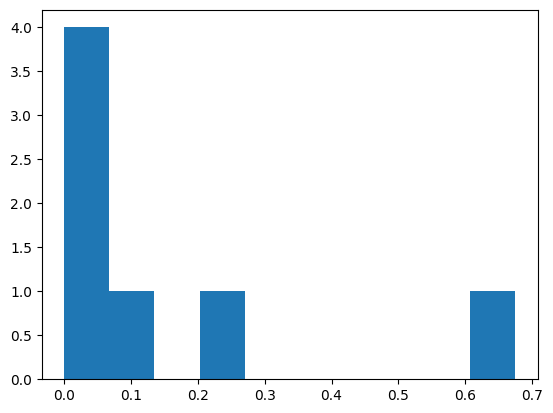

In [91]:
plt.hist(samples_for_plot[:,8])

In [9]:
input_file = '/projects/cosmo_database/ntriantafyllou/DATABASE_21cmFASTv4/info/LHS_SAMPLES.json'
with open(input_file, 'r') as f:
    data = json.load(f)

In [3]:
for key in data:
    print(key)

## Initial Coinditions

In [29]:
# Format the parameters 
user_params = dict(hdf['simulation_parameters']['user_params'].attrs)
cosmo_params = dict(hdf['simulation_parameters']['cosmo_params'].attrs)
astro_params = dict(hdf['simulation_parameters']['astro_params'].attrs)
flag_options = dict(hdf['simulation_parameters']['flag_options'].attrs)



input_params_struct = p21c.InputParameters(
                cosmo_params=p21c.CosmoParams.new(cosmo_params),
                astro_params=p21c.AstroParams.new(astro_params),
                user_params=p21c.UserParams.new(user_params),
                flag_options=p21c.FlagOptions.new(flag_options),
                random_seed=hdf.attrs['random_seed'],
                node_redshifts = hdf['coeval_data'].attrs['node_redshifts'],
            )

/home/ntriantafyllou/.conda/envs/21cm-dev4/lib/python3.11/site-packages/py21cmfast/drivers/param_config.py:157: UserWarning: You are setting M_TURN > 8 when USE_MINI_HALOS=True. This is non-standard (but allowed), and usually occurs upon manual update of M_TURN
  warnings.warn(


In [32]:
input_params_struct

cosmo_params: CosmoParams(SIGMA_8=0.812432295828086, hlittle=0.6766, OMm=0.30964144154550644, OMb=0.04897468161869667, POWER_INDEX=0.9665)
user_params: UserParams(BOX_LEN=300.0, HII_DIM=200, DIM=600, NON_CUBIC_FACTOR=1.0, USE_FFTW_WISDOM=False, HMF='ST', USE_RELATIVE_VELOCITIES=True, POWER_SPECTRUM='CLASS', N_THREADS=8, PERTURB_ON_HIGH_RES=False, NO_RNG=False, USE_INTERPOLATION_TABLES=True, INTEGRATION_METHOD_ATOMIC='GAUSS-LEGENDRE', INTEGRATION_METHOD_MINI='GAUSS-LEGENDRE', USE_2LPT=True, MINIMIZE_MEMORY=False, KEEP_3D_VELOCITIES=False, SAMPLER_MIN_MASS=1000000000.0, SAMPLER_BUFFER_FACTOR=2.0, MAXHALO_FACTOR=1.5, N_COND_INTERP=200, N_PROB_INTERP=400, MIN_LOGPROB=-12.0, SAMPLE_METHOD='MASS-LIMITED', AVG_BELOW_SAMPLER=True, HALOMASS_CORRECTION=0.9, PARKINSON_G0=1.0, PARKINSON_y1=0.0, PARKINSON_y2=0.0, Z_HEAT_MAX=35.0, ZPRIME_STEP_FACTOR=1.02)
astro_params: AstroParams(HII_EFF_FACTOR=30.0, F_STAR10=-0.3358616454576451, ALPHA_STAR=0.3069071278869089, F_STAR7_MINI=-0.3358616454576451, ALPH

In [ ]:
varying_params['random_seed']

In [238]:
ICs = p21c.compute_initial_conditions(
    random_seed = 66, 
    inputs = input_params_struct,
    write = False,
)

KeyboardInterrupt: 

In [ ]:
plt.imshow(ICs.lowres_density[34,:,:])

In [114]:
x_field = ICs.lowres_density
X=x_field

In [166]:
np.mean(X+1)

x_field=X

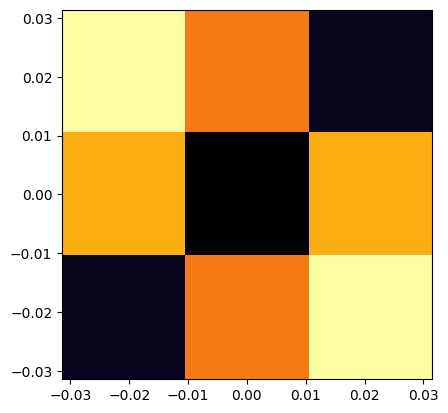

In [167]:
Nx     = x_field.shape[0] # box side pixel length
N      = Nx**3            # total number of voxels
loc_00 = int(Nx/2)        # location of k=(0,0,0) in the box
L      = 300              # real box side length (in Mpc)
Lx     = L/Nx             # real pixel length (in Mpc)
V      = L**3             # real volume (in Mpc^3)
Vx     = V/N              # real voxel volume (in Mpc)
a      = 1
b      = 1

k_field, k_allowed = pbox.dft.fft(x_field,L=300, a=1, b=1)
k_allowed = k_allowed[0]
powers = np.abs(k_field)**2
phases = np.angle(k_field)

kx     = k_allowed[1]-k_allowed[0]

pix_around=1
plt.imshow(  powers[loc_00-pix_around:loc_00+pix_around+1,   loc_00-pix_around:loc_00+pix_around+1,    loc_00]  
           , cmap='inferno'
           , extent=[-pix_around*kx-kx/2, pix_around*kx+kx/2,  -pix_around*kx-kx/2,pix_around*kx+kx/2]
#            , extent=[-1,1,-1,1]
           )

In [235]:
box = x_field
pk, meank = pbox.get_power(box, boxlength=300, ignore_zero_mode=True)

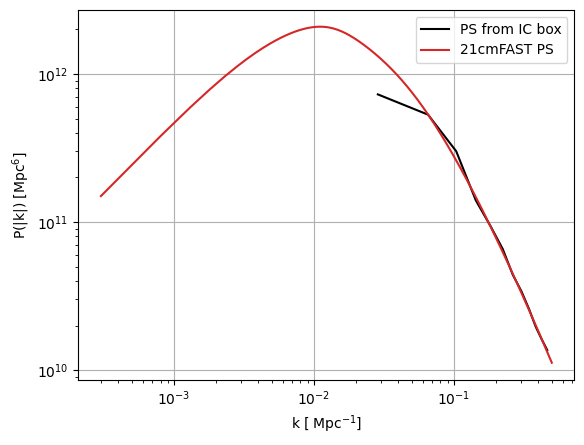

In [194]:
k=np.linspace(0.0003,0.5,1000)

plt.plot(meank[:12],pk[:12]*300**3, label='PS from IC box', color='black')
# plt.plot(k,power(k), c='teal', label='my PS')
plt.plot(k,power_21c(k), c= 'tab:red', label='21cmFAST PS')
# plt.axvline(k_norm(parameter_names[5]),linestyle='--',c='black', 
#             label=f'example sampling scale {round(k_norm(parameter_names[5]), 3)}')
plt.legend()
plt.ylabel(r'P(|k|) [$\rm Mpc^6]$')
plt.xlabel(r'k [$\rm  \; Mpc^{-1}$]')
plt.xscale('log')
plt.yscale('log')
plt.grid()

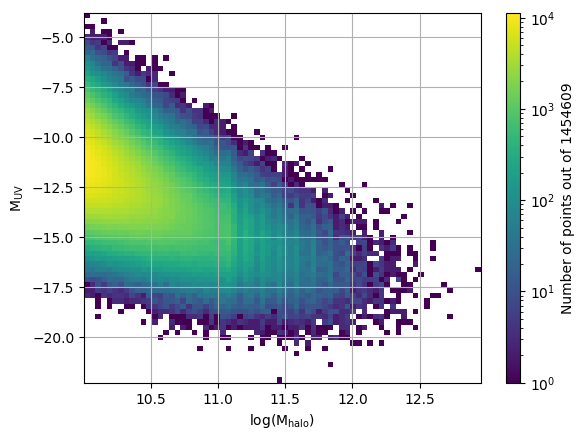

In [90]:

fig, ax = plt.subplots()
plt.hist2d(np.log10(hm_cat), Muv_cat,bins=70,alpha=1,
                     cmap='viridis',
                      norm='log'
                    )
plt.xlabel(r'$\rm log(M_{halo})$')
plt.ylabel(r'$\rm M_{UV}$')
plt.colorbar(label=f'Number of points out of {n_halos}', aspect=25)
plt.grid()

## Run a small thing to see where globals are

In [47]:
TEST_WITH_SMALL_RUN = True # If set to 'True' 21cmFast will run a 60Mpc box with 60x60x60 resolution up until z=34 

from astropy import units as un
random_seed=22
redshift = 5

if TEST_WITH_SMALL_RUN: 
    user_params["BOX_LEN"]=60.0
    user_params["HII_DIM"]=60
    redshift=34

print(user_params)
print("These are the new user params defaults:", p21c.UserParams.new(dict()))
print("These are the new flag options defaults:", p21c.FlagOptions.new(dict()))
cosmo_params_struct = p21c.CosmoParams.new(cosmo_params)
flag_options_struct = p21c.FlagOptions.new(flag_options)
astro_params_struct = p21c.AstroParams.new(astro_params)
user_params_struct = p21c.UserParams.new(user_params)


min_redshift=redshift
max_redshift=35.0


node_redshifts = p21c.get_logspaced_redshifts(min_redshift  = min_redshift,
                             max_redshift  = max_redshift,
                             z_step_factor = user_params['ZPRIME_STEP_FACTOR'])



input_params_struct = p21c.InputParameters(
                cosmo_params=cosmo_params_struct,
                astro_params=astro_params_struct,
                user_params=user_params_struct,
                flag_options=flag_options_struct,
                random_seed=random_seed,
                node_redshifts = node_redshifts,
            )


#Generate a LightConer instance, which defines the dimensions, angles and quantities desired
lightcone_quantities=("brightness_temp", 
                          'Ts_box',
                          'xH_box',
                          "density",
                          "Tk_box", 
                          "temp_kinetic_all_gas",
                          "Gamma12_box", 
                          "x_e_box", 
                          "n_ion",
                          'halo_mass','halo_sfr','halo_stars',
                         'halo_sfr_mini','halo_stars_mini',
                         'velocity_z'
                         )

global_quantities=("brightness_temp", 
                       'xH_box', 
                    #    'Tk_box', 
                       "temp_kinetic_all_gas")






lcn = p21c.RectilinearLightconer.with_equal_cdist_slices(
        min_redshift=redshift,
        max_redshift=35.0,
        resolution=user_params['BOX_LEN'] / user_params['HII_DIM'] * un.Mpc,
        quantities=lightcone_quantities,
)

import healpy as hp

lat, lon = np.pix2ang(np.arange(hp.nside2npix(128)), nside=128)

ang_lcn = p21c.AngularLightconer.with_equal_cdist_slices(
    min_redshift=redshift,    # or whatever
    max_redshift=35.0,   # or whatever
    quantities=('brightness_temp', 'density'),
    resolution=user_params.cell_size,
    latitude=lat,
    longitude=lon,
    get_los_velocity=True
)


iz, z, coev, lightcone = p21c.exhaust_lightcone(
        lightconer=[lcn, ang_lcn],
        inputs = input_params_struct,
        regenerate = True,
        global_quantities=global_quantities,
)


{'AVG_BELOW_SAMPLER': True, 'BOX_LEN': 60.0, 'DIM': 600, 'HALOMASS_CORRECTION': 0.9, 'HII_DIM': 60, 'HMF': 'ST', 'INTEGRATION_METHOD_ATOMIC': 'GAUSS-LEGENDRE', 'INTEGRATION_METHOD_MINI': 'GAUSS-LEGENDRE', 'KEEP_3D_VELOCITIES': False, 'MAXHALO_FACTOR': 1.5, 'MINIMIZE_MEMORY': False, 'MIN_LOGPROB': -12, 'NON_CUBIC_FACTOR': 1.0, 'NO_RNG': False, 'N_COND_INTERP': 200, 'N_PROB_INTERP': 400, 'N_THREADS': 8, 'PARKINSON_G0': 1.0, 'PARKINSON_y1': 0.0, 'PARKINSON_y2': 0.0, 'PERTURB_ON_HIGH_RES': False, 'POWER_SPECTRUM': 'CLASS', 'SAMPLER_BUFFER_FACTOR': 2.0, 'SAMPLER_MIN_MASS': 1000000000.0, 'SAMPLE_METHOD': 'MASS-LIMITED', 'USE_2LPT': True, 'USE_FFTW_WISDOM': False, 'USE_INTERPOLATION_TABLES': True, 'USE_RELATIVE_VELOCITIES': True, 'ZPRIME_STEP_FACTOR': 1.02, 'Z_HEAT_MAX': 35.0}
These are the new user params defaults: UserParams:AVG_BELOW_SAMPLER        : True
    BOX_LEN                  : 300.0
    DIM                      : 600
    HALOMASS_CORRECTION      : 0.9
    HII_DIM                  

AttributeError: module 'numpy' has no attribute 'pix2ang'

In [50]:
lightcone.global_params

{'ALPHA_UVB': 5.0,
 'EVOLVE_DENSITY_LINEARLY': 0,
 'SMOOTH_EVOLVED_DENSITY_FIELD': 0,
 'R_smooth_density': 0.20000000298023224,
 'HII_ROUND_ERR': 9.999999747378752e-06,
 'FIND_BUBBLE_ALGORITHM': 2,
 'N_POISSON': 5,
 'T_USE_VELOCITIES': 1,
 'MAX_DVDR': 0.20000000298023224,
 'DELTA_R_HII_FACTOR': 1.100000023841858,
 'DELTA_R_FACTOR': 1.100000023841858,
 'HII_FILTER': 0,
 'INITIAL_REDSHIFT': 300.0,
 'R_OVERLAP_FACTOR': 1.0,
 'DELTA_CRIT_MODE': 1,
 'HALO_FILTER': 0,
 'OPTIMIZE': 0,
 'OPTIMIZE_MIN_MASS': 99999997952.0,
 'CRIT_DENS_TRANSITION': 1.2000000476837158,
 'MIN_DENSITY_LOW_LIMIT': 9.000000034120603e-08,
 'RecombPhotonCons': 0,
 'PhotonConsStart': 0.9950000047683716,
 'PhotonConsEnd': 0.30000001192092896,
 'PhotonConsAsymptoteTo': 0.009999999776482582,
 'PhotonConsEndCalibz': 3.5,
 'PhotonConsSmoothing': 1,
 'HEAT_FILTER': 0,
 'CLUMPING_FACTOR': 2.0,
 'R_XLy_MAX': 500.0,
 'NUM_FILTER_STEPS_FOR_Ts': 40,
 'TK_at_Z_HEAT_MAX': -1.0,
 'XION_at_Z_HEAT_MAX': -1.0,
 'Pop': 2,
 'Pop2_ion': 50